In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from itertools import product
from numpy.linalg import cholesky
import plotly.graph_objs as go
import plotly.offline as po

In [51]:
from numpy.linalg import cholesky
import pandas as pd
import numpy as np

corr = pd.DataFrame([[1,0.9,0.6],[0.9,1,0.7],[0.6,0.7,1]])
vol = [0.01,0.01,0.01]
C = cholesky(corr)
k = pd.Series([1,0,0])
r = np.multiply(np.matmul(C,k).transpose(),vol)
r

     0    1    2
0  1.0  0.9  0.6
1  0.9  1.0  0.7
2  0.6  0.7  1.0
[[1.         0.         0.        ]
 [0.9        0.43588989 0.        ]
 [0.6        0.36706517 0.71081865]]


array([0.01 , 0.009, 0.006])

In [39]:

expret = [5,8,12,15]
expvol = [3,7,12,18]
corr = pd.DataFrame([[1,0.5,0.1,-0.6],[0.5,1.0,0.2,0.1],[0.1,0.2,1.0,0.5],[-0.6,0.1,0.5,1.0]],columns=expvol,index=expvol)
covar = corr.copy()
for i,j in product(expvol,repeat=2):
    covar.loc[i,j] = corr.loc[i,j]*i*j


    
x0 = [0.25,0.25,0.25,0.25]
bnds = ((0, 1), (0, 1),(0, 1),(0, 1))

#minimize variance for each level of return
def por_var(x):
    return np.dot(np.matmul(x,covar),x)
def w(x):
    return np.sum(x)-1

eff={}
ws={}
for i in range(min(expret)*2,max(expret)*2+1):
    r = i/2

    def port_ret(x):
        return np.dot(x,expret)-r
    cons= [{'type': 'eq', 'fun': port_ret},{'type': 'eq', 'fun': w}]
    res = minimize(por_var,x0,bounds=bnds,constraints=cons)
    eff[r] = np.sqrt(por_var(res.x))
    ws[r] = res.x

eff = pd.Series(eff)





In [75]:
#maximize return for each level of variance 
cons= [{'type': 'eq', 'fun': w}] #constraints for global minimum variance portfolio
gmvp = minimize(por_var,x0,bounds=bnds,constraints=cons) # weights of GMVP
min_v = np.sqrt(por_var(gmvp.x)) # minimum volatility possible
max_v = np.max(expvol)


def mvo(rr):
    eff_v={}
    eff_x={}
    for q in range(int(np.ceil(min_v)),max_v+1,3):
        def varp(x):
            return np.dot(np.matmul(x,covar),x)-q**2
        def rfun(x):
            return -np.dot(x,rr)
        cons  = [{'type': 'eq', 'fun': varp},{'type': 'eq', 'fun': w}]
        res = minimize(rfun,x0,bounds=bnds,constraints=cons)

        eff_v[q] = -rfun(res.x)
        eff_x[q] = res.x

    return pd.Series(eff_v),pd.DataFrame(eff_x)

eff_v,xxx= mvo(expret)

In [41]:
def scat(traces,annots=[]):
  layout = go.Layout(width=550,height=400,margin=dict(l=50,r=20,b=30,t=50),template='plotly_white',
                    annotations=annots,
                    showlegend=False,
                    title={'text':'<b>Efficient Frontier </b> ','xanchor':'left','font':{'size':10}},
                  )
  fig = go.Figure(data=traces, layout=layout)
  po.init_notebook_mode(connected=True)
  config = {'showLink':False}
  po.iplot(fig,config=config)

     

traces=[]
temp = eff.iloc[2:]
traces.append(go.Scatter(x=temp,y=temp.index,mode='lines+markers',line={'color':'dodgerblue'},marker={'size':6,'color':'blue'}))
traces.append(go.Scatter(x=eff_v.index,y=eff_v,mode='lines+markers',line={'color':'purple'},marker={'size':6,'color':'purple'}))
traces.append(go.Scatter(x=expvol,y=expret,mode='markers',marker={'size':7,'color':'red'},opacity=0.7))
annots = [{'x':temp.loc[i]+1.5,'y':i,'text':'('+str(temp.round(1).loc[i])+','+str(i)+')','showarrow':False,'font':{'size':8,'color':'blue'}} for i in temp.index]

scat(traces,annots)


In [42]:
#Resample eficient frontier:
# 1. 10k observations of uncorrelated random variables Z~N(0,1)
# 2. chelosky decompose correlation matrix to generate correlated random variables by transforming Z. 
# 3. correlated returns rij =  Mui + Zij*voli for each asset class i for each iteration j.
# 4. find eficient frontier at each iteration using correlated random returns found in 3. 
# 5. find the mean of the optimized weights at each pair r,vol on the EF. 
from numpy.linalg import cholesky
corr = #[4,4]
expvol = #[4]
expret = #[4]
n = 100
C = cholesky(corr)
Zu = np.random.normal(size=(len(expret),n))
Zc = np.matmul(C,Zu).transpose()

Mu = np.tile(expret,(n,1))
S = np.tile(expvol,(n,1)) 
R = Mu + -(S**2/2)/100 +np.multiply(Zc,S)



In [51]:
ref_=[]
ws_=[]
for i in R:
    ri,wi =mvo(i)
    ref_.append(ri)
    ws_.append(wi)


In [77]:
ref_df = pd.concat(ref_,axis=1).transpose()

mean_ref = ref_df.mean(axis=0)
traces=[]
temp = eff.iloc[2:]
traces.append(go.Scatter(x=eff_v.index,y=eff_v,mode='lines',line={'color':'purple'}))
traces.append(go.Scatter(x=expvol,y=expret,mode='markers',marker={'size':7,'color':'red'},opacity=0.7))
traces.append(go.Scatter(x=mean_ref.index,y=mean_ref,mode='lines',line={'color':'black'}))
for c in [3,6,9,12,15,18]:
     traces.append(go.Violin(y=ref_df.loc[:,c],jitter=0.2,pointpos=-0.5,
            points='outliers',name=c,side='negative',meanline_visible=True,
            marker={'size':2,'color':'black','opacity':0.4},line={'width':0.5,'color':'gray'}))
scat(traces)

In [63]:
nueve=[]
for i in ws_:
    nueve.append(i.loc[:,6])

nueve = pd.concat(nueve,axis=1).mean(axis=1).round(2)
nueve

0    0.37
1    0.32
2    0.16
3    0.15
dtype: float64

In [36]:
traces=[]
traces.append(go.Scatter(x=Zc[:,0],y=Zc[:,3],mode='markers',marker={'color':'blue','size':2},opacity=0.8))
traces.append(go.Scatter(x=Zu[0,:],y=Zu[3,:],mode='markers',marker={'color':'red','size':5},opacity=0.8))
print(corr)
scat(traces)

     3    7    12   18
3   1.0  0.5  0.1 -0.6
7   0.5  1.0  0.2  0.1
12  0.1  0.2  1.0  0.5
18 -0.6  0.1  0.5  1.0


<function matplotlib.pyplot.show(close=None, block=None)>

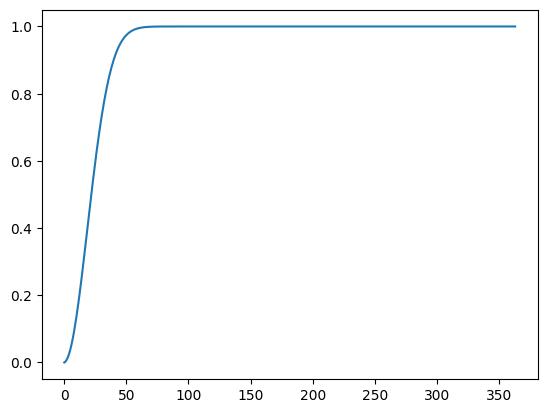

In [4]:
import math
import matplotlib.pyplot as plt
def birthday(k):
    return 1- math.factorial(365)/((365**k)*math.factorial(365-k))
    
x = [birthday(i) for i in range(1,365)]
plt.plot(x)
plt.show